In [1]:
import pandas as pd


In [2]:
vaccinations_data = pd.read_csv('data/country_vaccinations.csv')
vaccinations_data = vaccinations_data[
    ['country', 'date', 'total_vaccinations', 
     'people_vaccinated', 'people_vaccinated_per_hundred',
     'people_fully_vaccinated', 'people_fully_vaccinated_per_hundred',
     'daily_vaccinations', 'vaccines']
]

In [3]:
covid_data = pd.read_csv('data/covid_data.csv')
display(covid_data.head())

,date,province/state,country,confirmed,deaths,recovered
0,01/22/2020,Anhui,China,1.0,0.0,0.0
1,01/22/2020,Beijing,China,14.0,0.0,0.0
2,01/22/2020,Chongqing,China,6.0,0.0,0.0
3,01/22/2020,Fujian,China,1.0,0.0,0.0
4,01/22/2020,Gansu,China,0.0,0.0,0.0


## Предобработка данных
Группируем таблицу по дате и названию страны и рассчитываем суммарные показатели по всем регионам. Тем самым переходим от данных по регионам к данным по странам:

In [4]:
covid_data = covid_data.groupby(
    ['date', 'country'], 
    as_index=False
)[['confirmed', 'deaths', 'recovered']].sum()

Преобразуем даты в формат datetime с помощью функции pd.to_datetime():

In [5]:
covid_data['date'] = pd.to_datetime(covid_data['date'])

Создадим признак больных на данный момент (active). Для этого вычтем из общего числа зафиксированных случаев число смертей и число выздоровевших пациентов:

In [6]:
covid_data['active'] = covid_data['confirmed'] - covid_data['deaths'] - covid_data['recovered']

Создадим признак ежедневного прироста числа заболевших, умерших и выздоровевших людей. Для этого отсортируем данные по названиям стран, а затем по датам. После этого произведём группировку по странам и рассчитаем разницу между «вчера и сегодня» с помощью метода diff():

In [7]:
covid_data = covid_data.sort_values(by=['country', 'date'])
covid_data['daily_confirmed'] = covid_data.groupby('country')['confirmed'].diff()
covid_data['daily_deaths'] = covid_data.groupby('country')['deaths'].diff()
covid_data['daily_recovered'] = covid_data.groupby('country')['recovered'].diff()

В таблице vaccinations_data достаточно будет преобразовать столбцы в формат datetime:

In [8]:
vaccinations_data['date'] = pd.to_datetime(vaccinations_data['date'])

## 3.1.

In [9]:
display(covid_data['date'].min(), covid_data['date'].max())


Timestamp('2020-01-22 00:00:00')

Timestamp('2021-05-29 00:00:00')

In [10]:
covid_data.tail(1)

,date,country,confirmed,deaths,recovered,active,daily_confirmed,daily_deaths,daily_recovered
17645,2020-03-17,occupied Palestinian territory,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3.2.

In [11]:
display(vaccinations_data['date'].min(), vaccinations_data['date'].max())


Timestamp('2020-12-02 00:00:00')

Timestamp('2021-09-06 00:00:00')

## 3.3.

In [12]:
covid_df = covid_data.merge(vaccinations_data, how='left', on=['date', 'country'])
covid_df.shape
covid_df.head(5)

,date,country,confirmed,deaths,recovered,active,daily_confirmed,daily_deaths,daily_recovered,total_vaccinations,people_vaccinated,people_vaccinated_per_hundred,people_fully_vaccinated,people_fully_vaccinated_per_hundred,daily_vaccinations,vaccines
0,2020-02-24,Afghanistan,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-25,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-26,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-27,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-28,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3.4.

In [13]:
covid_df['death_rate'] = covid_df['deaths'] / covid_df['confirmed'] * 100
covid_df[covid_df['country'] == 'United States']['death_rate'].max()

7.18954248366013

## 3.5.

In [14]:
covid_df['recover_rate'] = covid_df['recovered'] / covid_df['confirmed'] * 100
covid_df[covid_df['country'] == 'Russia']['recover_rate'].mean()

67.06273489477655

# 4. Графические возможности библиотеки Pandas

<Axes: title={'center': 'Ежедневная заболеваемость во времени'}, xlabel='date'>

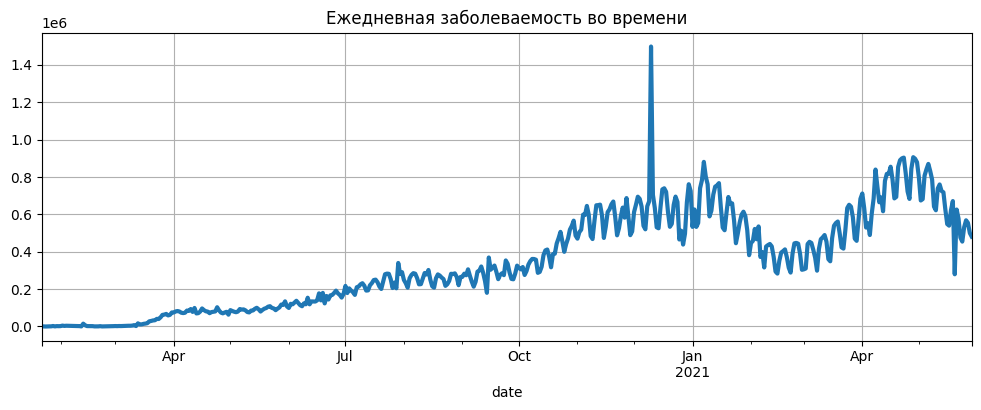

In [15]:
grouped_cases = covid_df.groupby('date')['daily_confirmed'].sum()
grouped_cases.plot(
    kind='line',
    figsize=(12, 4),
    title='Ежедневная заболеваемость во времени',
    grid = True,
    lw=3
)

<Axes: title={'center': 'Распределение ежедневной заболеваемости'}, ylabel='Frequency'>

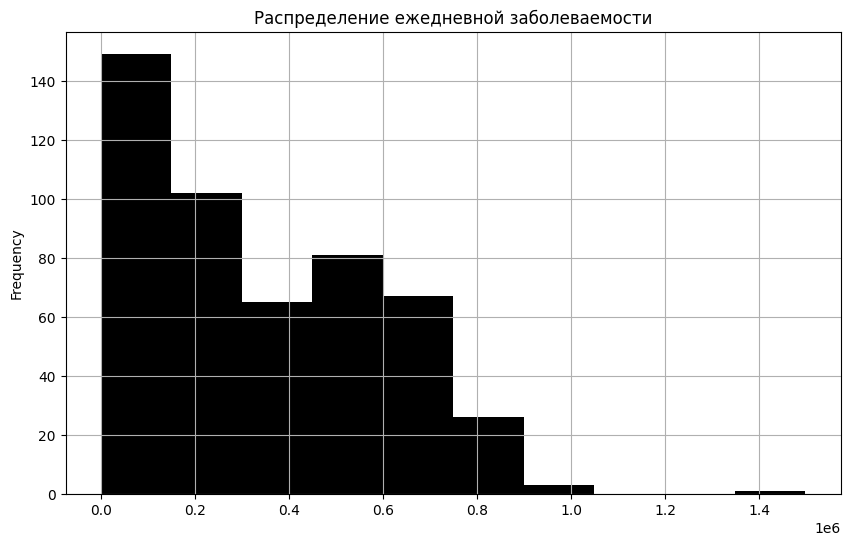

In [16]:
grouped_cases.plot(
    kind='hist',
    figsize=(10, 6),
    title='Распределение ежедневной заболеваемости',
    grid = True,
    color = 'black',
    bins=10
)

<Axes: xlabel='country'>

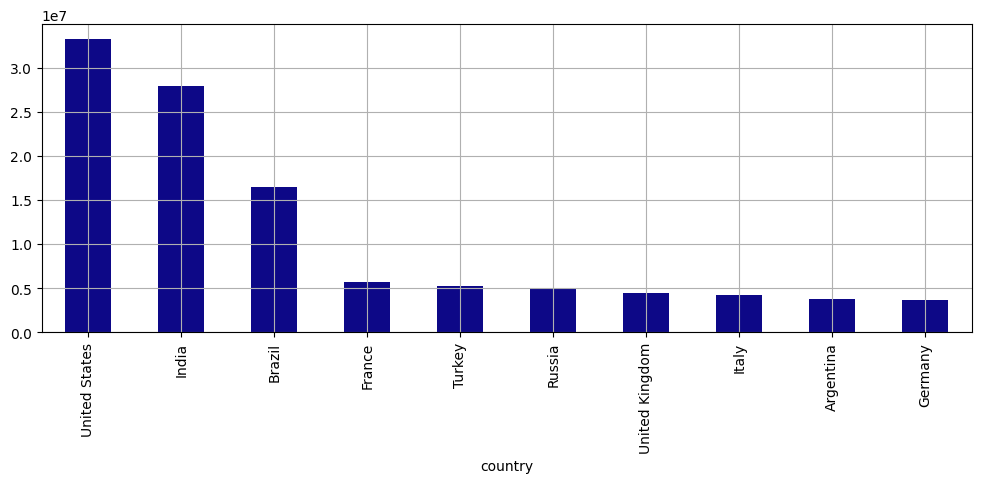

In [17]:
grouped_country = covid_df.groupby(['country'])['confirmed'].last()
grouped_country = grouped_country.nlargest(10)
grouped_country.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4),
    colormap='plasma'
)

<Axes: xlabel='country'>

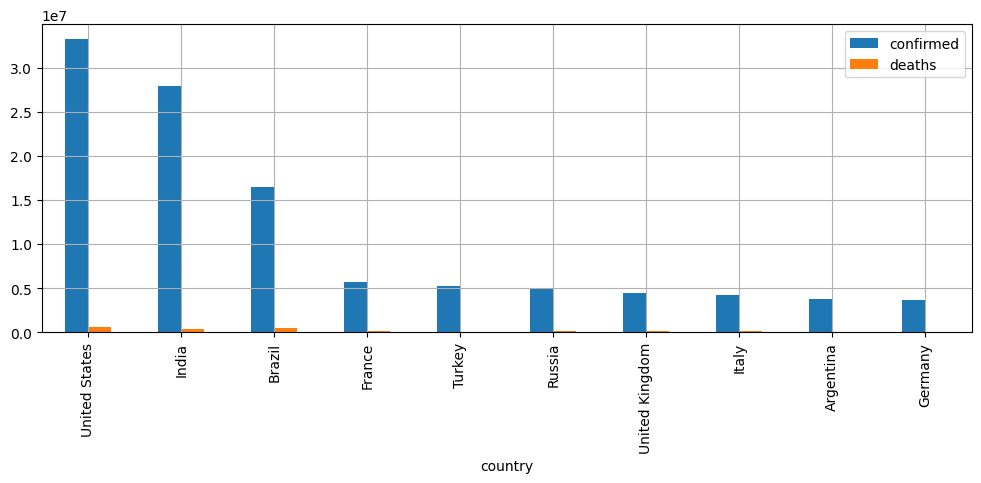

In [18]:
grouped_country = covid_df.groupby(['country'])[['confirmed', 'deaths']].last()
grouped_country = grouped_country.nlargest(10, columns=['confirmed'])
grouped_country.plot( 
    kind='bar', 
    grid=True, 
    figsize=(12, 4), 
)

<Axes: xlabel='country'>

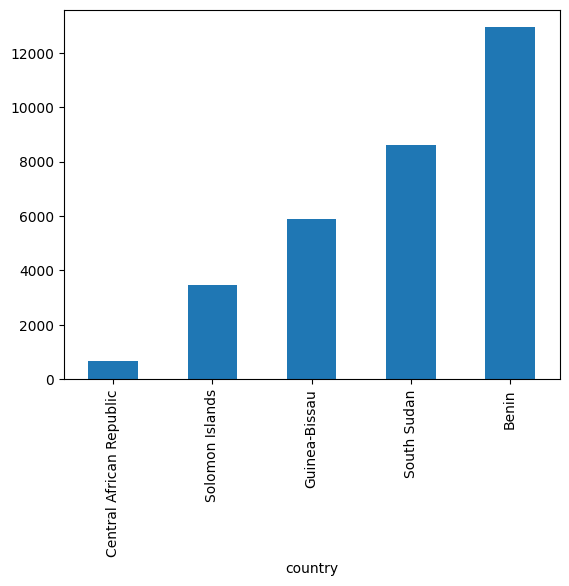

In [19]:
covid_df.groupby(['country'])['total_vaccinations'].last().nsmallest(5).plot(kind='bar')

# Seaborn

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
countries = ['Russia', 'Australia', 'Germany', 'Canada', 'United Kingdom']
croped_covid_df = covid_df[covid_df['country'].isin(countries)]

populations = pd.DataFrame([
    ['Canada', 37664517],
    ['Germany', 83721496],
    ['Russia', 145975300],
    ['Australia', 25726900],
    ['United Kingdom', 67802690]
    ],
    columns=['country', 'population']
)
croped_covid_df = croped_covid_df.merge(populations, on=['country'])
croped_covid_df['daily_confirmed_per_hundred'] = croped_covid_df['daily_confirmed'] / croped_covid_df['population'] * 100
croped_covid_df.head()

,date,country,confirmed,deaths,recovered,active,daily_confirmed,daily_deaths,daily_recovered,total_vaccinations,people_vaccinated,people_vaccinated_per_hundred,people_fully_vaccinated,people_fully_vaccinated_per_hundred,daily_vaccinations,vaccines,death_rate,recover_rate,population,daily_confirmed_per_hundred
0,2020-01-23,Australia,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25726900,NaN
1,2020-01-25,Australia,4.0,0.0,0.0,4.0,4.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,25726900,0.000016
2,2020-01-26,Australia,4.0,0.0,0.0,4.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,25726900,0.000000
3,2020-01-27,Australia,5.0,0.0,0.0,5.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,25726900,0.000004
4,2020-01-28,Australia,5.0,0.0,0.0,5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,25726900,0.000000


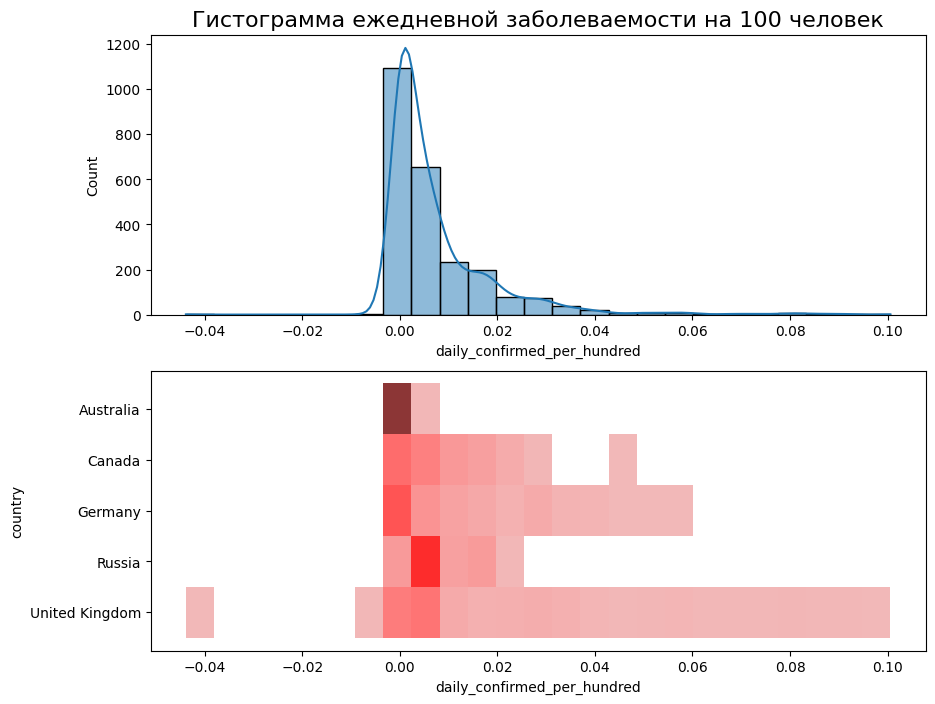

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
sns.histplot(
    data=croped_covid_df,
    x='daily_confirmed_per_hundred',
    bins=25,
    kde=True,
    ax=axes[0]
);
axes[0].set_title('Гистограмма ежедневной заболеваемости на 100 человек', fontsize=16)
sns.histplot(
    data=croped_covid_df,
    x='daily_confirmed_per_hundred',
    y='country',
    bins=25,
    color='red',
    ax=axes[1]
);


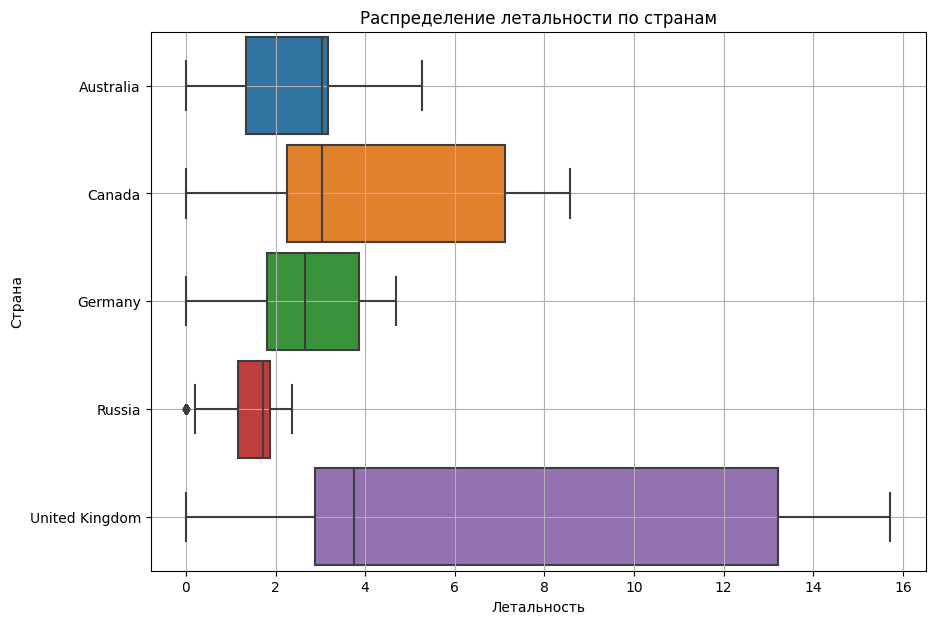

In [25]:
fig = plt.figure(figsize=(10, 7))
boxplot = sns.boxplot(
    data=croped_covid_df,
    y='country',
    x='death_rate',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение летальности по странам');
boxplot.set_xlabel('Летальность');
boxplot.set_ylabel('Страна');
boxplot.grid()

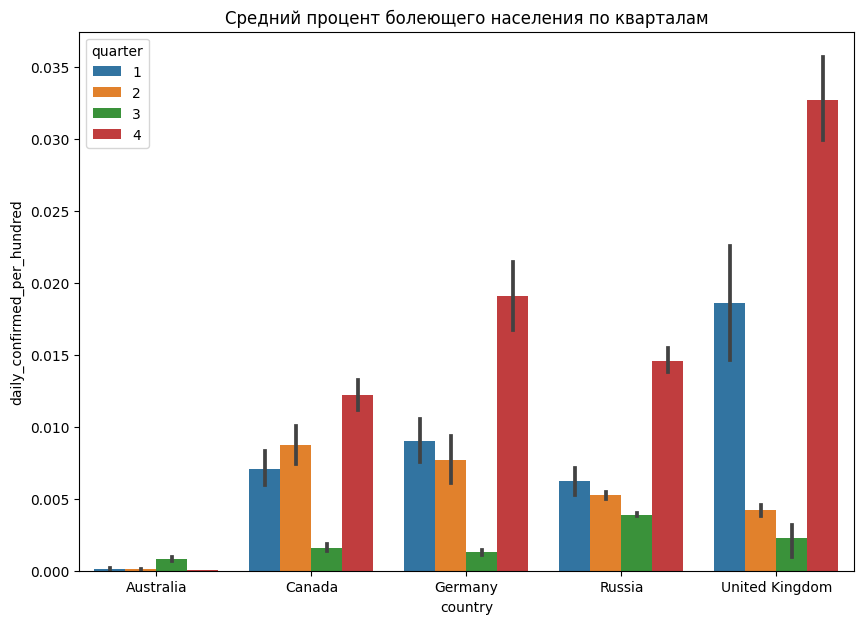

In [26]:
fig = plt.figure(figsize=(10, 7))
croped_covid_df['quarter'] = croped_covid_df['date'].dt.quarter
barplot = sns.barplot(
    data=croped_covid_df,
    x='country',
    y='daily_confirmed_per_hundred',
    hue='quarter',
)
barplot.set_title('Средний процент болеющего населения по кварталам');

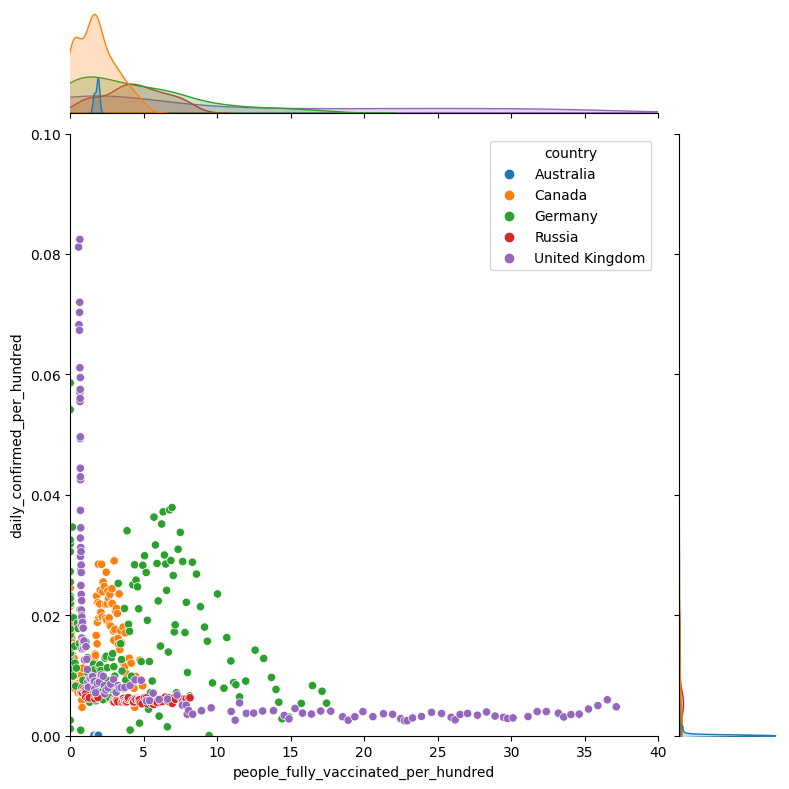

In [27]:
jointplot = sns.jointplot(
    data=croped_covid_df, 
    x='people_fully_vaccinated_per_hundred', 
    y='daily_confirmed_per_hundred',
    hue='country',
    xlim = (0, 40),
    ylim = (0, 0.1),
    height=8,
)

In [28]:
pivot = croped_covid_df.pivot_table(
    values='people_vaccinated_per_hundred',
    columns='date',
    index='country',
)
pivot.columns = pivot.columns.astype('string')
display(pivot)

date,2020-12-13,2020-12-14,2020-12-15,2020-12-16,2020-12-17,2020-12-18,2020-12-19,2020-12-20,2020-12-21,2020-12-22,...,2021-05-20,2021-05-21,2021-05-22,2021-05-23,2021-05-24,2021-05-25,2021-05-26,2021-05-27,2021-05-28,2021-05-29
country,,,,,,,,,,,,,,,,,,,,,
Australia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,12.40,12.69,12.88,13.28,13.73,14.18
Canada,NaN,0.0,0.00,0.01,0.02,0.03,0.03,0.03,0.05,0.07,...,48.10,49.25,50.14,50.89,51.77,52.39,53.05,53.95,54.99,55.71
Germany,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39.18,39.68,39.95,40.11,40.29,40.64,41.29,41.87,42.40,42.61
Russia,NaN,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,0.04,...,10.20,10.30,10.50,10.53,10.70,10.81,11.07,11.12,11.19,11.29
United Kingdom,0.13,NaN,NaN,NaN,NaN,NaN,NaN,0.99,NaN,NaN,...,55.01,55.33,55.63,55.82,55.99,56.27,56.61,56.99,57.29,57.56


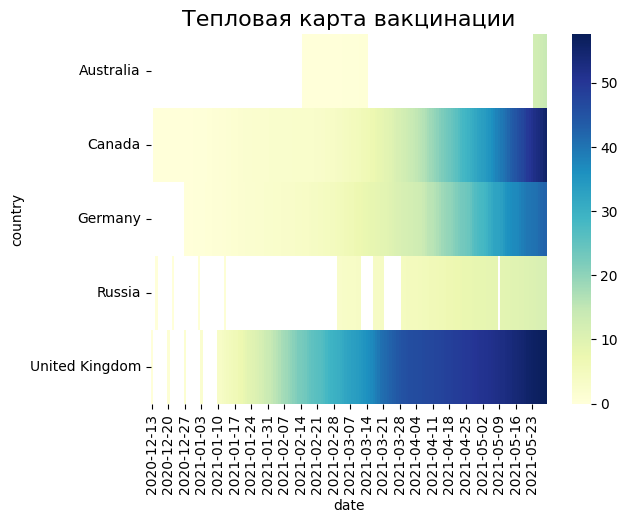

In [29]:
heatmap = sns.heatmap(data=pivot, cmap='YlGnBu')
heatmap.set_title('Тепловая карта вакцинации', fontsize=16);

## 6.4.

In [38]:
croped_covid_df['confirmed_per_hundred'] = croped_covid_df['confirmed'] / croped_covid_df['population'] * 100
pivot2 = croped_covid_df.pivot_table(
    values='confirmed_per_hundred',
    columns='date',
    index='country',
)
pivot2.columns = pivot2.columns.astype('string')
display(pivot2)

date,2020-01-23,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,...,2021-05-20,2021-05-21,2021-05-22,2021-05-23,2021-05-24,2021-05-25,2021-05-26,2021-05-27,2021-05-28,2021-05-29
country,,,,,,,,,,,,,,,,,,,,,
Australia,0.0,0.000016,0.000016,0.000019,0.000019,0.000019,0.000035,0.000035,0.000047,0.000047,...,0.116606,0.116621,0.116637,0.116683,0.116722,0.116788,0.116854,0.116897,0.116932,0.116983
Canada,NaN,NaN,0.000003,0.000003,0.000005,0.000005,0.000008,0.000008,0.000011,0.000011,...,3.599497,3.611526,3.620169,3.628017,3.632706,3.642529,3.648718,3.661252,3.669520,3.675536
Germany,NaN,NaN,NaN,NaN,0.000005,0.000005,0.000005,0.000006,0.000010,0.000012,...,4.345962,4.355632,4.363299,4.368845,4.371625,4.374704,4.380047,4.388347,4.395716,4.401106
Russia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000001,0.000001,0.000001,...,3.368999,3.375035,3.380916,3.386963,3.392637,3.397954,3.403604,3.409708,3.415960,3.422232
United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000003,0.000003,0.000003,...,6.594230,6.598223,6.601946,6.605033,6.608528,6.612093,6.616504,6.621495,6.627439,6.632219


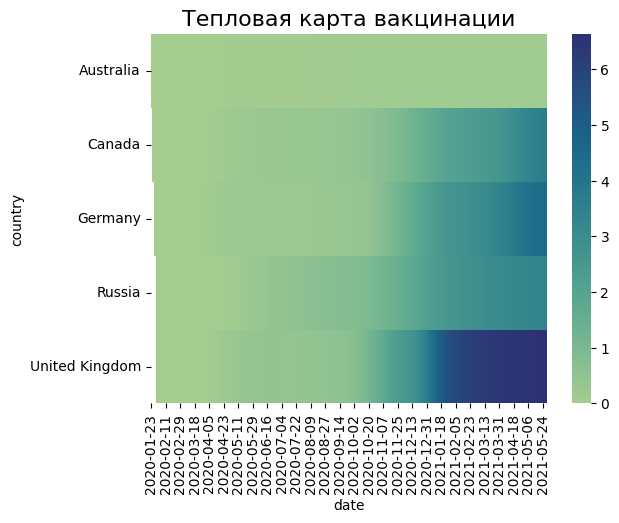

In [39]:
heatmap = sns.heatmap(data=pivot2, cmap='crest')
heatmap.set_title('Тепловая карта вакцинации', fontsize=16);

## 6.5

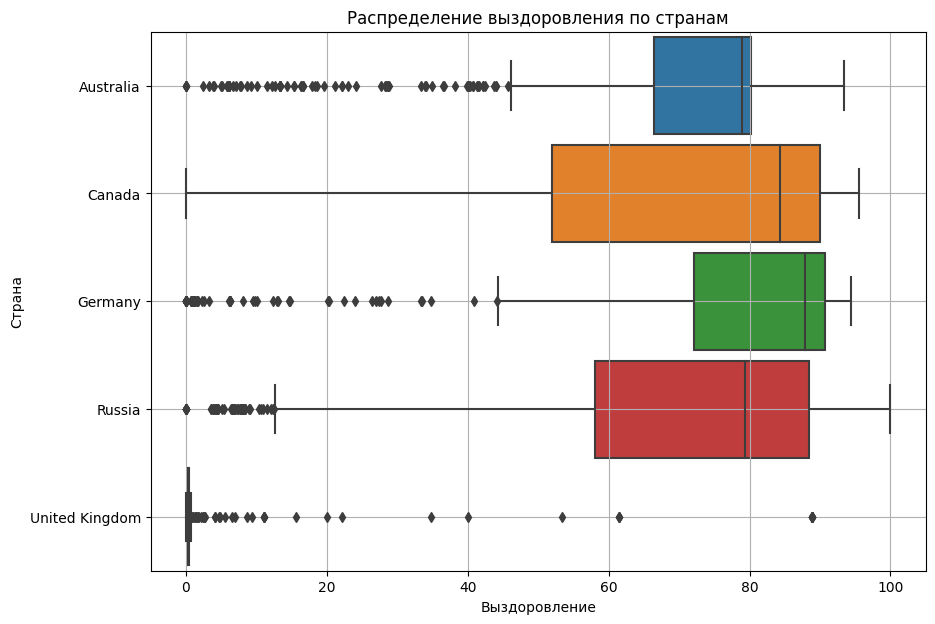

In [40]:
fig = plt.figure(figsize=(10, 7))
boxplot = sns.boxplot(
    data=croped_covid_df,
    y='country',
    x='recover_rate',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение выздоровления по странам');
boxplot.set_xlabel('Выздоровление');
boxplot.set_ylabel('Страна');
boxplot.grid()

# Plotly

In [42]:
import plotly
import plotly.express as px

In [44]:
line_data = covid_df.groupby('date', as_index=False).sum()
fig = px.line(
    data_frame=line_data, #DataFrame
    x='date', #ось абсцисс
    y=['confirmed', 'recovered', 'deaths', 'active'], #ось ординат
    height=500, #высота
    width=1000, #ширина
    title='Confirmed, Recovered, Deaths, Active cases over Time' #заголовок
)
fig.show()

C:\Users\ak88r\AppData\Local\Temp\ipykernel_12068\1527933100.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed